출처 : 
- 딥러닝을 위한 최적화와 수치해석 (황윤구, 양한별, 남가람북스) 
- https://github.com/DNRY/dlopt

|  |  |
|---|---|
| ![](imgs/optimizers.gif) | ![](imgs/optimizers_2.gif) |

# 7장. 딥러닝을 위한 수치최적화 알고리즘

## 7.2 스토캐스틱 방법의 코드 구현 패턴

⸻

### 전체 데이터 N개를 모두 사용할 때 손실함수 E의 그래디언트

$$
\nabla E = \frac{2}{N} \sum_{i=1}^{N}
\begin{bmatrix}
x_i \\[3pt]
1
\end{bmatrix}
(ax_i + b - y_i)
$$
여기서
- $x_i$: 입력값 (input)
- $y_i$: 실제값 (target or label)
- $a$, $b$: 모델의 파라미터 (기울기와 절편)
- $N$: 전체 데이터의 개수

즉, 모든 데이터를 이용해 평균 제곱 오차(MSE)의 기울기를 계산하는 식

⸻

### 확률적 경사하강법(Stochastic Gradient Descent) 근사식
- 전체 데이터 대신 임의로 추출한 m개의 데이터만을 사용해 그래디언트를 근사

$$
\nabla E \approx \frac{2}{m} \sum_{j=1}^{m}
\begin{bmatrix}
x_{r_j} \\[3pt]
1
\end{bmatrix}
(a x_{r_j} + b - y_{r_j})
$$
여기서
- $r_j$: 임의로 선택된 샘플
- $r_1$, $r_2$, $\ldots$, $r_m$: 1부터 N 사이에서 임의로 선택된 샘플 인덱스
- $m$: 선택된 데이터(부분집합, mini-batch)의 크기

즉, 전체 평균 대신 랜덤 표본 평균으로 근사하는 형태

의미 요약
- 위 두 식은 모두 경사하강법의 기본 구조를 표현하지만,
  - 첫 번째는 “정확한 전체 평균”
  - 두 번째는 “확률적 근사”를 사용
- 후자의 식이 바로 SGD(Stochastic Gradient Descent)의 핵심

$$
\nabla E = \frac{2}{N}\sum_{i=1}^{N}
\begin{bmatrix}
x_i \\ 1
\end{bmatrix}
(ax_i + b - y_i)
\approx
\frac{2}{m}\sum_{j=1}^{m}
\begin{bmatrix}
x_{r_j} \\ 1
\end{bmatrix}
(a x_{r_j} + b - y_{r_j})
$$

In [126]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(320)

x_train = np.linspace(-1, 1, 50)
f = lambda x: 0.5 * x + 1.0
y_train = f(x_train) + 0.5 * np.random.rand(len(x_train))

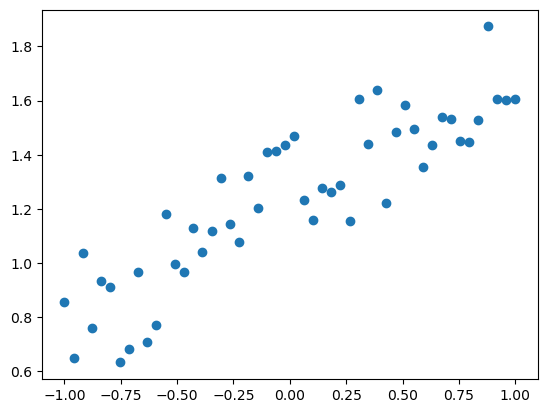

In [127]:
plt.scatter(x_train, y_train)
plt.show()

### 손실함수와 그라디언트

- 데이터: $\{(x_i, y_i)\}_{i=1}^N$
- 모델(선형회귀): $\hat{y}_i = w_0 x_i + w_1$, 파라미터 $w = [w_0, w_1]^T$

손실함수(평균 제곱오차, 반 계수 포함):
$$
L(w) \;=\; \frac{1}{N}\sum_{i=1}^{N} \frac{1}{2}\,\big(w_0 x_i + w_1 - y_i\big)^2
$$
- 앞의 $\tfrac{1}{2}$는 미분 시 계수 2를 상쇄해 수식을 단순화
- 본 문제는 $w$에 대해 볼록한(quadratic) 목적함수

그라디언트:
$$
\nabla L(w)
= \begin{bmatrix}
\frac{\partial L}{\partial w_0} \\
\frac{\partial L}{\partial w_1}
\end{bmatrix}
= \frac{1}{N}\sum_{i=1}^{N} \big(w_0 x_i + w_1 - y_i\big)\begin{bmatrix}x_i \\ 1\end{bmatrix}
$$

성분 형태:
$$
\frac{\partial L}{\partial w_0} = \frac{1}{N}\sum_{i=1}^{N} \big(w_0 x_i + w_1 - y_i\big) x_i,\qquad
\frac{\partial L}{\partial w_1} = \frac{1}{N}\sum_{i=1}^{N} \big(w_0 x_i + w_1 - y_i\big)
$$

미니배치/확률적 그라디언트:
- 단일 샘플 $i$: $g_i(w)=\big(w_0 x_i + w_1 - y_i\big)[x_i,\,1]^T$
- 미니배치 $B$: 
$$
g_B(w) \;=\; \frac{1}{|B|}\sum_{i\in B} \big(w_0 x_i + w_1 - y_i\big)\,[x_i,\,1]^T
$$

아래 셀 구현과의 매핑:
- loss(w, x_set, y_set) → 위의 $L(w)$를 $x_i\in\text{x\_set}$에 대해 평균
- loss_grad(w, x_set, y_set) → 위의 $\nabla L(w)$를 $x_i\in\text{x\_set}$에 대해 평균
- 미니배치일 때 x_set, y_set은 배치 $B$에 해당하며, 전체 데이터면 $N$ 전부에 대해 평균

In [128]:
# 손실함수
def loss(w, x_set, y_set):
    N = len(x_set)
    val = 0.0
    for i in range(len(x_set)):
        val += 0.5 * ( w[0] * x_set[i] + w[1] - y_set[i] )**2 # w[0]: a, w[1]: b
    return val / N

#손실함수의 그래디언트
def loss_grad(w, x_set, y_set):
    N = len(x_set)
    val = np.zeros(len(w))
    for i in range(len(x_set)):
        er = w[0] * x_set[i] + w[1] - y_set[i] # w[0]: a, w[1]: b
        val += er * np.array([x_set[i], 1.0])
    return val / N

In [129]:
idx = np.arange(len(x_train))
print(idx)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [130]:
np.random.shuffle(idx)
print(idx)

[32 17 47 33  1  7 23 19 21 40  3 14 18  0  4 12 42 41 25 10  2 36 31  6
 16 24 11 22 45 46 49 15 38 48  8 37 30  9 35 13 28 34 29 27 39 26 20 44
  5 43]


In [131]:
def generate_batches(batch_size, features, labels):
    outout_batches = []
    sample_size = len(features)
    
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches

In [132]:
for x_batch, y_batch in generate_batches(3, x_train, y_train):
    print(f'{x_batch:}, \t{y_batch}\n')

[-1.         -0.95918367 -0.91836735], 	[0.85717699 0.64839147 1.03747097]

[-0.87755102 -0.83673469 -0.79591837], 	[0.76157041 0.93583858 0.91343921]

[-0.75510204 -0.71428571 -0.67346939], 	[0.63326206 0.6814117  0.96710997]

[-0.63265306 -0.59183673 -0.55102041], 	[0.70941863 0.77067192 1.1814767 ]

[-0.51020408 -0.46938776 -0.42857143], 	[0.99806755 0.968902   1.12913494]

[-0.3877551  -0.34693878 -0.30612245], 	[1.0405742  1.11900683 1.31290467]

[-0.26530612 -0.2244898  -0.18367347], 	[1.14295054 1.07854175 1.32169846]

[-0.14285714 -0.10204082 -0.06122449], 	[1.20252924 1.40960218 1.41370172]

[-0.02040816  0.02040816  0.06122449], 	[1.43614323 1.46867001 1.23415307]

[0.10204082 0.14285714 0.18367347], 	[1.16041035 1.27658599 1.26085818]

[0.2244898  0.26530612 0.30612245], 	[1.28958814 1.15640936 1.60732703]

[0.34693878 0.3877551  0.42857143], 	[1.44104725 1.64040609 1.22182815]

[0.46938776 0.51020408 0.55102041], 	[1.48395658 1.58279759 1.49543186]

[0.59183673 0.63265306 0

## 7.3 탐색 방향 기반 알고리즘

### 7.3.1 스토캐스틱 그래디언트 디센트 방법

##### 목적함수
- 모델: $\hat{y}_i = w_0 x_i + w_1$, 파라미터 $w = [w_0, w_1]^T$
- 손실: $L(w) = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{2}\big(w_0 x_i + w_1 - y_i\big)^2$

##### 전체 그래디언트
- $\nabla L(w) = \frac{1}{N}\sum_{i=1}^{N} \big(w_0 x_i + w_1 - y_i\big)\,[x_i,\,1]^T$

##### 확률적/미니배치 그래디언트
- 단일 샘플 $i$: $g_i(w) = \nabla \ell_i(w) = \big(w_0 x_i + w_1 - y_i\big)\,[x_i,\,1]^T$
- 미니배치 $B$: $g_B(w) = \frac{1}{|B|}\sum_{i\in B} \big(w_0 x_i + w_1 - y_i\big)\,[x_i,\,1]^T$

##### 업데이트 규칙
- $w_{t+1} = w_t - \eta_t\, g_B(w_t)$
- 여기서 $\eta_t$는 학습률(learning rate)

##### 구현과의 매핑
- lr ↔ $\eta_t$, batch_size ↔ $|B|$
- loss_grad(...) ↔ $g_B(w)$
- generate_batches(...) ↔ 배치 $B$ 생성
- w0 ↔ 현재 파라미터, paths ↔ 파라미터 경로 추적

##### 실무 팁
- 에폭마다 데이터 셔플링으로 배치 상관을 줄임
- $\eta_t$가 너무 크면 발산, 너무 작으면 수렴이 느림 → 초기 크게 후 점감, 스케줄/적응형(Adagrad/RMSProp/Adam) 고려

In [133]:
# SGD
batch_size = 5 # 배치 크기
lr = 0.1 # 학습률
MaxEpochs = 10 # 반복 횟수

paths = []
batch_loss = []

w0 = np.array([4.0, -1.0]) # 1) 초깃값
search_direction = np.zeros_like(w0)

# 2) 데이터 셔플링
np.random.seed(320)
idx = np.arange(len(x_train))
np.random.shuffle(idx)

shuffled_x_train = x_train[idx]
shuffled_y_train = y_train[idx]

In [134]:
# 알고리즘
for epoch in range(MaxEpochs+1): # 5) MaxEpochs번 반복
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train): # 3) 미니 배치 생성
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        grad = loss_grad(w0, x_batch, y_batch) # 4)-1 미니 치에서 그래디언트 계산
        search_direction = -grad # 4)-2 탐색 방향 설정
        lr = lr # 4)-3 학습률 설정
        
        # 4)-4 파라미터 업데이트
        dw = lr * search_direction 
        w0 = w0 + dw
        
    print('epoch: {:02d}\tw: {}\tloss: {:5.4f}'.format(epoch, w0, loss(w0, x_train, y_train)))

epoch: 00	w: [2.90612619 0.44668386]	loss: 1.3759
epoch: 01	w: [2.15422995 0.9520445 ]	loss: 0.5588
epoch: 02	w: [1.63340183 1.1300777 ]	loss: 0.2615
epoch: 03	w: [1.27122542 1.19383436]	loss: 0.1298
epoch: 04	w: [1.01888237 1.21737871]	loss: 0.0676
epoch: 05	w: [0.84289406 1.22655399]	loss: 0.0377
epoch: 06	w: [0.72009763 1.23044437]	loss: 0.0233
epoch: 07	w: [0.63439547 1.23228919]	loss: 0.0163
epoch: 08	w: [0.57457506 1.23327536]	loss: 0.0130
epoch: 09	w: [0.53281774 1.23385931]	loss: 0.0114
epoch: 10	w: [0.5036684  1.23423077]	loss: 0.0106


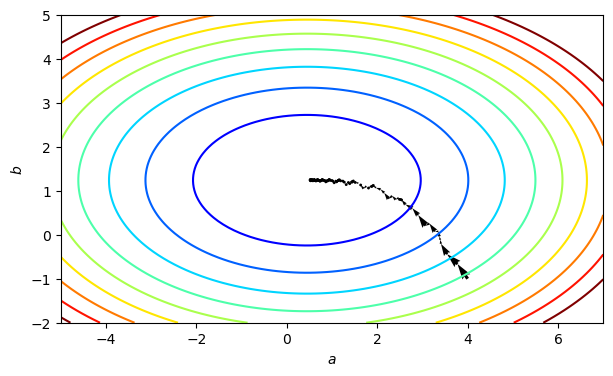

In [135]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

def contour_with_path(l, x, y, paths, norm=LogNorm(),level=np.logspace(0, 5, 35), minima=None):
    paths = np.array(paths).T
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.contour(x, y, l, levels=level, norm=norm, cmap=plt.cm.jet)
    ax.quiver(paths[0, :-1], paths[1, :-1], paths[0, 1:]-paths[0, :-1], paths[1, 1:]-paths[1, :-1],
        scale_units='xy', angles='xy', scale=1, color='k')
    if minima is not None:
        ax.plot(*minima, 'r*', markersize=18)

    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    plt.show()

W0 = np.linspace(-5, 7, 101)
W1 = np.linspace(-2, 5, 101)
W0, W1 = np.meshgrid(W0, W1)
LOSSW = W0 * 0
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        wij = np.array([W0[i, j], W1[i, j]])
        LOSSW[i, j] = loss(wij, x_train, y_train)

contour_with_path(LOSSW, W0, W1, paths, norm=None, level=np.linspace(0, 10, 10))

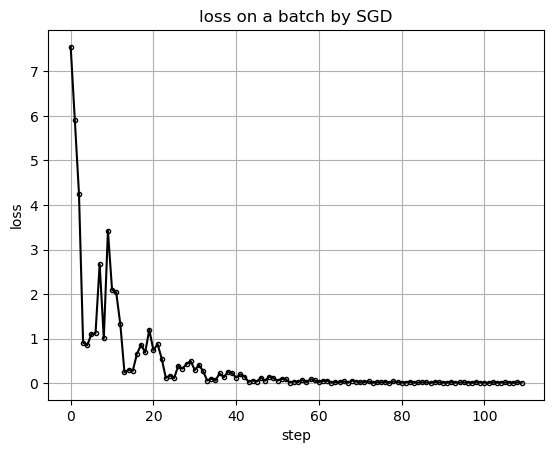

In [136]:
plt.plot(batch_loss, '.-k', markerfacecolor='none')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by SGD')
plt.show()

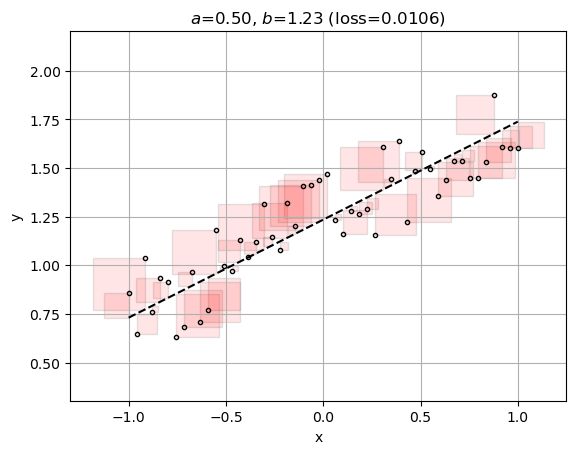

In [137]:
from matplotlib.patches import Rectangle
def visualize_l2(w, b, x_train, y_train, loss):
    from matplotlib.patches import Rectangle
    loss_name = 'loss'
    plt.plot(x_train, y_train, '.k', markerfacecolor='none')
    plt.plot(x_train, w * x_train + b, '--k')
    currentAxis = plt.gca()
    for xx,yy in zip(x_train, y_train):
        currentAxis.add_patch(Rectangle((xx, yy), 
                                        w * xx + b - yy, w * xx + b - yy,
                              alpha=0.1, facecolor='red', edgecolor='k'))
    plt.grid()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("$a$={:1.2f}, $b$={:1.2f} (loss={:5.4f})".format(w, b, loss))
    
visualize_l2(w0[0], w0[1], x_train, y_train, loss(w0, x_train, y_train))

### 7.3.2 모멘텀/네스테로프 방법

#### 모멘텀

- 기존의 그래디언트(기울기)를 그대로 따르지 않고, 이전 이동방향(velocity)을 일정 비율로 유지하면서 새 그래디언트를 더함
- 즉, “이전 속도 + 현재 힘”

수식

$$ v_t = \alpha v_{t-1} - \eta \nabla_\theta L(\theta_t) $$
$$ \theta_{t+1} = \theta_t + v_t $$

여기서
- $v_t$: 현재 속도 (velocity)
- $\alpha$: 모멘텀 계수(보통 0.9 정도)
- $\eta$: 학습률
- $\nabla_\theta L(\theta_t)$: 현재 위치에서의 그래디언트

In [138]:
# Momentum
batch_size = 5 # 배치 크기
epsilon = 0.03 # 학습률
MaxEpochs = 10 # 반복 횟수

w0 = np.array([4.0, -1.0]) # 1) 초깃값

alpha = 0.9
velocity = np.zeros_like(w0)
paths = []
batch_loss = []

In [139]:
# 2) 데이터 셔플링 전과 동일

# 알고리즘
for epoch in range(MaxEpochs+1): # 5) MaxEpochs번 반복
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train): # 3) 미니 배치 생성
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        grad = loss_grad(w0, x_batch, y_batch) # 4)-1 미니 배치에서 그래디언트 계산        
        epsilon = epsilon # 4)-2 학습률 설정
        velocity = alpha * velocity - epsilon * grad # 4)-3 탐색 방향 설정
        
        dw = velocity # 4)-4 파라미터 업데이트
        w0 = w0 + dw
        
    print('{:02d}\t{}\t{:5.4f}'.format(epoch, w0, loss(w0, x_train, y_train)))

00	[2.53616213 1.11712583]	0.7769
01	[0.71010882 1.99960646]	0.3113
02	[-0.07224185  1.16140806]	0.0592
03	[-0.02453239  1.00236237]	0.0761
04	[0.27892071 1.31815837]	0.0178
05	[0.49031735 1.31700082]	0.0134
06	[0.53652217 1.2026128 ]	0.0122
07	[0.49279808 1.22021849]	0.0106
08	[0.44579318 1.25831166]	0.0102
09	[0.42824408 1.24716194]	0.0101
10	[0.43162513 1.23600131]	0.0100


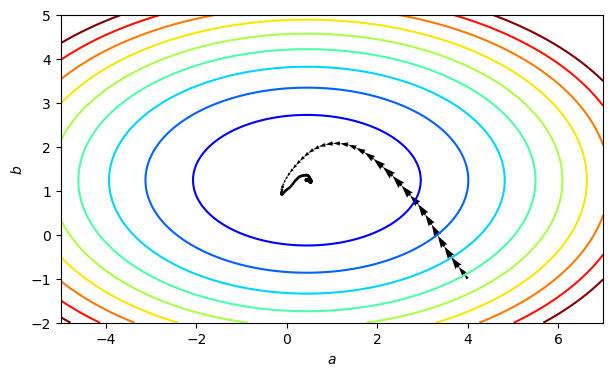

In [140]:
contour_with_path(LOSSW, W0, W1, paths, norm=None, level=np.linspace(0, 10, 10))

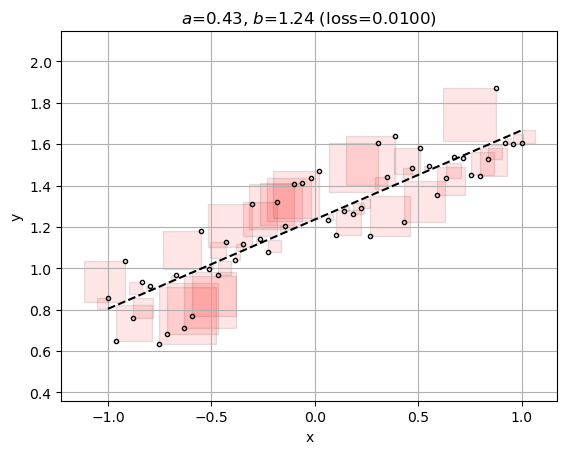

In [141]:
visualize_l2(w0[0], w0[1], x_train, y_train, loss(w0, x_train, y_train))

#### 네스테로프 (Nesterov Accelerated Gradient, NAG)

문제의식
- 모멘텀은 “현재 위치에서” 그래디언트를 계산
- 하지만 실제로는, 이미 관성에 의해 앞으로 조금 더 나아가 있어 “조금 앞선 위치에서” 기울기를 미리 계산
- 시간은 t-1 시점이지만, 그 속도는 앞으로 나아가려는 관성의 방향

수식
$$v_t = \alpha v_{t-1} - \eta \nabla_\theta L(\theta_t - \alpha v_{t-1}) $$
$$\theta_{t+1} = \theta_t + v_t$$

여기서
- $v_{t-1}$: $_{t-1}$ 시점 속도 (velocity)
- $\alpha$: 모멘텀 계수(보통 0.9 정도)
- $\eta$: 학습률
- $\nabla_\theta L(\theta_t)$: 현재 위치에서의 그래디언트

In [142]:
# Nesterov
batch_size = 5 # 뱃치 크기
epsilon = 0.03 # 학습율
MaxEpochs = 10 # 반복 횟수

w0 = np.array([4.0, -1.0]) # 1) 초기값

alpha = 0.9
velocity = np.zeros_like(w0)
paths = []
batch_loss = []

# 2) 데이터 셔플링
np.random.seed(320)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
shuffled_x_train = x_train[idx]
shuffled_y_train = y_train[idx]

In [143]:
# 알고리즘
for epoch in range(MaxEpochs+1): # 5) MaxEpochs번 반복
    
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train): # 3) 미니 뱃치 생성
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))        
        
        grad = loss_grad(w0 + alpha * velocity, x_batch, y_batch) # 4)-1 미니 뱃치에서 그래디언트 계산
        velocity = alpha * velocity - epsilon * grad # 4)-2 탐색방향 설정
        epsilon = epsilon # 4)-3 학습율 설정
        
        dw = velocity # 4)-4 파라미터 업데이트
        w0 = w0 + dw
        
    print('{:02d}\t{}\t{:5.4f}'.format(epoch, w0, loss(w0, x_train, y_train)))

00	[2.55769373 0.97625293]	0.8198
01	[0.82465965 1.80965296]	0.1978
02	[0.0631574  1.25368725]	0.0352
03	[0.05159922 1.10383614]	0.0458
04	[0.2815584 1.2589649]	0.0147
05	[0.45227668 1.27769713]	0.0107
06	[0.50050973 1.2332066 ]	0.0106
07	[0.47982957 1.23218949]	0.0102
08	[0.4502372  1.24428516]	0.0100
09	[0.43610401 1.24393478]	0.0100
10	[0.43533936 1.24106763]	0.0100


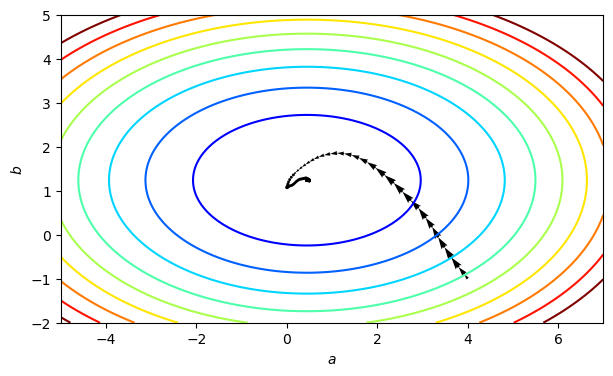

In [144]:
contour_with_path(LOSSW, W0, W1, paths, norm=None, level=np.linspace(0, 10, 10))

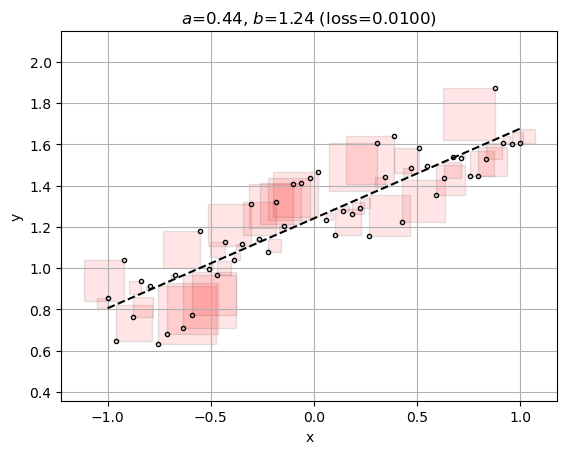

In [145]:
visualize_l2(w0[0], w0[1], x_train, y_train, loss(w0, x_train, y_train))

## 7.4 학습률 기반 알고리즘

### 7.4.1 적응형 학습률 방법의 필요성

$$
\theta_{t+1} =
\begin{cases}
\theta_t - \eta_t \nabla L(\theta_t), & \text{if } L(\theta_t - \eta_t \nabla L(\theta_t)) < L(\theta_t) \\
\theta_t, & \text{otherwise (and reduce } \eta_t = \eta_t / 2)
\end{cases}
$$

In [146]:
# 적응형 알고리즘
batch_size = 5 # 배치 크기
lr = 2.0 # 학습률
MaxEpochs = 10 # 반복 횟수

w0 = np.array([4.0, -1.0]) # 1) 초깃값
search_direction = np.zeros_like(w0)

paths = []
batch_loss = []

# 2) 데이터 셔플링은 생략합니다.

In [147]:
# 알고리즘
for epoch in range(MaxEpochs+1): # 5) MaxEpochs번 반복
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train): # 3) 미니 배치 생성
        paths.append(w0)
        
        batch_loss.append(loss(w0, x_batch, y_batch))
        grad = loss_grad(w0, x_batch, y_batch) # 4)-1 미니 배치에서 그래디언트 계산
        
        search_direction = -grad # 4)-2 탐색 방향 설정
        lr = lr # 4)-3 학습률 설정
        
        # 4)-4 파라미터 업데이트
        dw = lr * search_direction 
        w1 = w0 + dw
        
        # 적응형 알고리즘 예
        loss0, loss1 = loss(w0, x_train, y_train), loss(w1, x_train, y_train)
        if loss0 > loss1:
            w0 = w1
        else:
            lr = lr / 2
    print('{:02d}\t{}\t{:5.4f}'.format(epoch, w0, loss(w0, x_train, y_train)))

00	[0.57875075 1.2844077 ]	0.0142
01	[0.46371043 1.2465671 ]	0.0101
02	[0.46325046 1.24364981]	0.0101
03	[0.46317506 1.24367345]	0.0101
04	[0.4631727  1.24367419]	0.0101
05	[0.46317263 1.24367421]	0.0101
06	[0.46317263 1.24367421]	0.0101
07	[0.46317263 1.24367421]	0.0101
08	[0.46317263 1.24367421]	0.0101
09	[0.46317263 1.24367421]	0.0101
10	[0.46317263 1.24367421]	0.0101


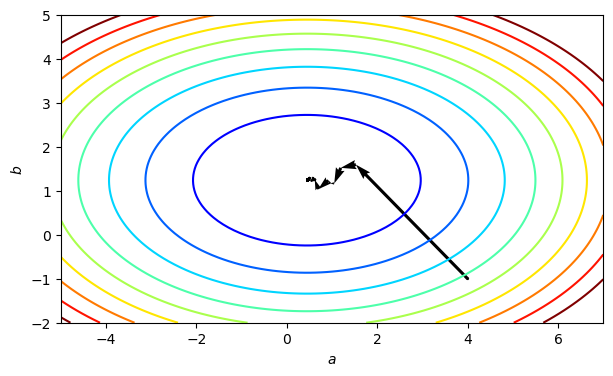

In [148]:
W0 = np.linspace(-5, 7, 101)
W1 = np.linspace(-2, 5, 101)
W0, W1 = np.meshgrid(W0,W1)
LOSSW = W0 * 0
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        wij = np.array([W0[i,j], W1[i,j]])
        LOSSW[i,j] = loss(wij, x_train, y_train)

contour_with_path(LOSSW, W0, W1, paths, norm=None, level=np.linspace(0, 10, 10))

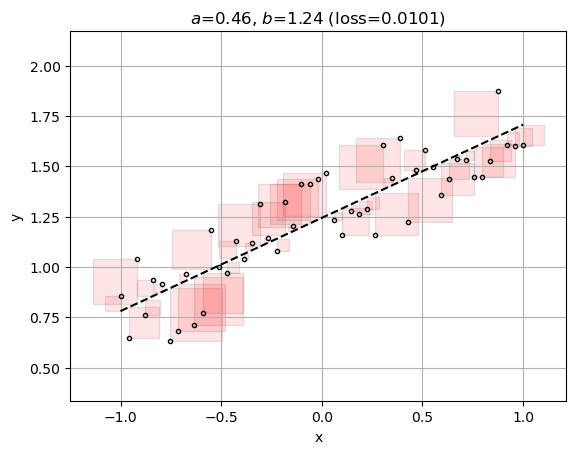

In [149]:
visualize_l2(w0[0], w0[1], x_train, y_train, loss(w0, x_train, y_train))

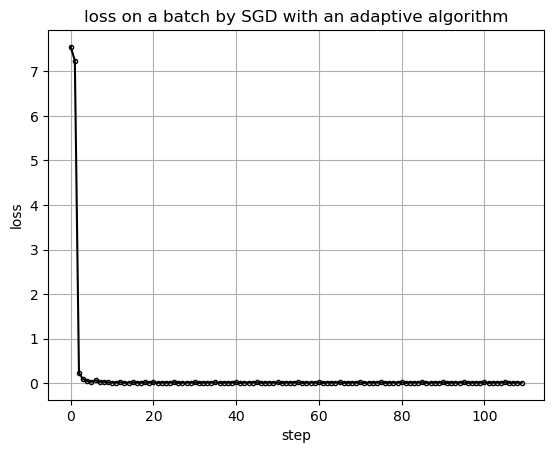

In [150]:
plt.plot(batch_loss, '.-k', markerfacecolor='none')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by SGD with an adaptive algorithm')
plt.show()

### 7.4.2 Adagrad

- 모든 파라미터가 같은 속도로 “학습”하므로 희소(sparse) 데이터에서는 비효율적 
- 자주 등장하는 특징(feature)은 과도하게 업데이트 드물게 등장하는 특징은 거의 학습이 되지 않는 문제 발생

수식 

각 step t에서:
1.	그래디언트 계산 $$g_t = \nabla_\theta L(\theta_t)$$

2.	그래디언트 제곱 누적 $$ G_t = G_{t-1} + g_t \odot g_t $$ 

3.	가중치 업데이트 $$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot g_t$$


즉, 파라미터 $_i$에 대한 실제 학습률은

$$\eta_{t,i} = \frac{\eta}{\sqrt{G_{t,i} + \epsilon}}$$


각 파라미터 i에 대해 보면:

$$\theta_{t+1,i} = \theta_{t,i} - \frac{\eta}{\sqrt{\sum_{\tau=1}^t g_{\tau,i}^2 + \epsilon}} g_{t,i}$$

즉,
- 각 파라미터마다 누적 그래디언트 제곱이 클수록 denominator가 커지고 → step size가 줄어듬
- 반대로 잘 등장하지 않는 파라미터는 denominator가 작으므로 → 상대적으로 더 크게 움직임

In [151]:
# Adagrad
batch_size = 5 # 배치 크기
MaxEpochs = 2 # 반복 횟수

w0 = np.array([2.0, 4.0]) # 1) 초깃값
epsilon = 1.0
delta = 1E-7
r = np.zeros_like(w0)

paths = []
batch_loss = []

print('Iter\tw_k\t\tgrad\t\tdw\t\tloss')
print('{:01d}-{:02d}\t{}'.format(1,0,np.array2string(w0, formatter={'float_kind':lambda x: "%.2f" % x})))

# 2) 데이터 셔플링 : 생략

# 알고리즘
for epoch in range(MaxEpochs): # 5) MaxEpochs번 반복
    k = 0
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train): # 3) 미니 배치 생성
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        grad = loss_grad(w0, x_batch, y_batch) # 4)-1 미니 배치에서 그래디언트 계산
        search_direction = -grad # 4)-2 탐색 방향 설정
        
        # 4)-3 학습률 설정
        r = r  + grad * grad
        lr = epsilon / (delta + np.sqrt(r)) 
        
        dw = lr * search_direction # 4)-4 파라미터 업데이트
        w0 = w0 + dw
        
        print('{:01d}-{:02d}\t{}\t{}\t{}\t{:5.4f}'.format(epoch+1,k +1, np.array2string(w0, 
            formatter={'float_kind':lambda x: "%.2f" % x}), 
            np.array2string(grad, formatter={'float_kind':lambda x: "%.2f" % x}), 
            np.array2string(dw, formatter={'float_kind':lambda x: "%.2f" % x}), 
            loss(w0, x_train, y_train)))
        k += 1

Iter	w_k		grad		dw		loss
1-00	[2.00 4.00]
1-01	[3.00 3.00]	[-0.29 2.32]	[1.00 -1.00]	2.6936
1-02	[2.02 2.45]	[1.40 1.52]	[-0.98 -0.55]	1.1778
1-03	[1.80 2.16]	[0.33 0.84]	[-0.22 -0.29]	0.7556
1-04	[1.55 1.80]	[0.38 1.12]	[-0.25 -0.36]	0.3796
1-05	[1.35 1.57]	[0.31 0.75]	[-0.20 -0.23]	0.2053
1-06	[1.28 1.46]	[0.10 0.35]	[-0.06 -0.11]	0.1563
1-07	[1.00 1.28]	[0.46 0.57]	[-0.28 -0.17]	0.0648
1-08	[0.92 1.30]	[0.13 -0.04]	[-0.08 0.01]	0.0511
1-09	[0.72 1.19]	[0.33 0.35]	[-0.20 -0.11]	0.0249
1-10	[0.63 1.25]	[0.16 -0.19]	[-0.09 0.06]	0.0161
2-01	[0.62 1.24]	[0.02 0.02]	[-0.01 -0.01]	0.0154
2-02	[0.56 1.23]	[0.10 0.02]	[-0.06 -0.01]	0.0123
2-03	[0.50 1.26]	[0.10 -0.10]	[-0.06 0.03]	0.0109
2-04	[0.52 1.28]	[-0.03 -0.04]	[0.02 0.01]	0.0117
2-05	[0.50 1.28]	[0.03 -0.01]	[-0.02 0.00]	0.0114
2-06	[0.50 1.27]	[0.00 0.02]	[-0.00 -0.01]	0.0111
2-07	[0.46 1.25]	[0.07 0.07]	[-0.04 -0.02]	0.0101
2-08	[0.49 1.23]	[-0.06 0.06]	[0.03 -0.02]	0.0104
2-09	[0.44 1.21]	[0.09 0.07]	[-0.05 -0.02]	0.0103
2-10	[0.

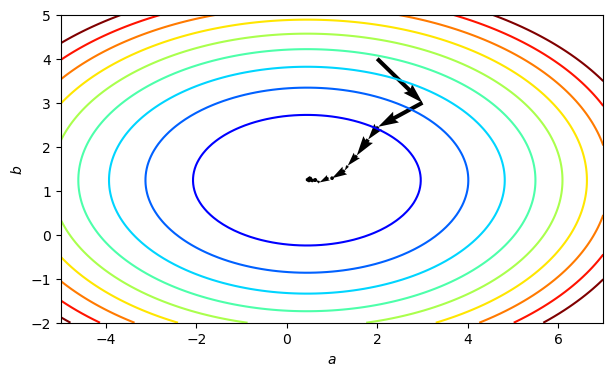

In [152]:
W0 = np.linspace(-5, 7, 101)
W1 = np.linspace(-2, 5, 101)
W0, W1 = np.meshgrid(W0,W1)
LOSSW = W0 * 0
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        wij = np.array([W0[i,j], W1[i,j]])
        LOSSW[i,j] = loss(wij, x_train, y_train)

contour_with_path(LOSSW, W0, W1, paths, norm=None, level=np.linspace(0, 10, 10))

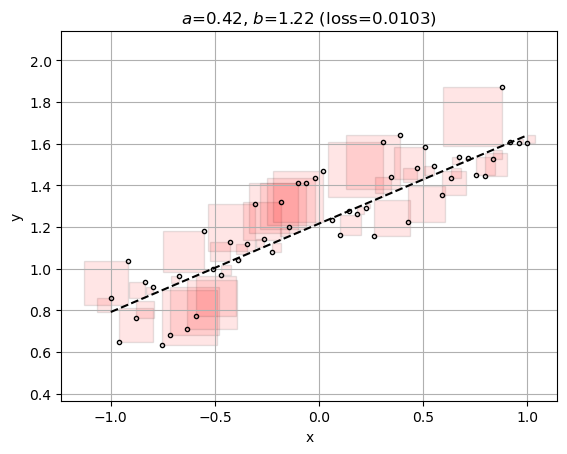

In [153]:
visualize_l2(w0[0], w0[1], x_train, y_train, loss(w0, x_train, y_train))

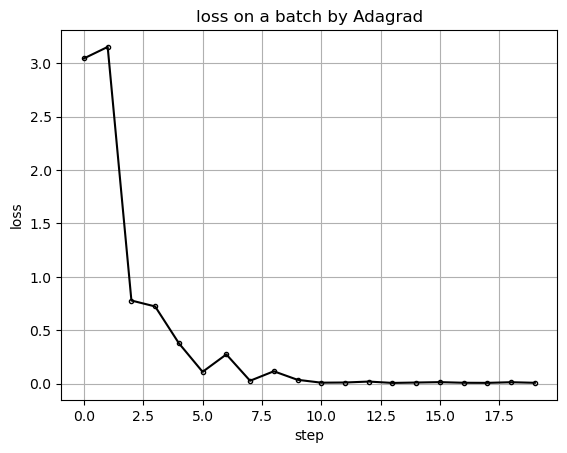

In [154]:
plt.plot(batch_loss, '.-k', markerfacecolor='none')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by Adagrad')
plt.show()

### 7.4.3 RMSProp

- 아다그라드는 모든 과거 그래디언트를 누적하므로, 학습이 진행될수록 학습률이 0에 가까워지는 문제가 존재함  
- RMSProp은 이 문제를 해결하기 위해 **그래디언트 제곱의 지수이동평균(Exponential Moving Average, EMA)** 을 사용함  
- 오래된 그래디언트 정보의 영향은 점점 줄이고, 최근의 그래디언트 정보를 더 크게 반영함  
- 이를 통해 **학습률이 너무 빨리 감소하지 않도록 조정**함  

#### 수식

각 step $_t$에서:

1. **그래디언트 계산**  
   $$
   g_t = \nabla_\theta L(\theta_t)
   $$

2. **그래디언트 제곱의 지수이동평균 계산**  
   $$
   E[g^2]_t = \rho E[g^2]_{t-1} + (1 - \rho) g_t \odot g_t
   $$

   - $\rho$: decay rate (보통 0.9)  
   - 오래된 gradient 제곱은 점차 잊히며, 최근 gradient에 더 큰 가중치를 부여함

3. **가중치 업데이트**  
   $$
   \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} \odot g_t
   $$


즉, 파라미터 $_i$에 대한 **실제 학습률**은  
$$
\eta_{t,i} = \frac{\eta}{\sqrt{E[g^2]_{t,i} + \epsilon}}
$$

각 파라미터 $_i$에 대해 보면:
$$
\theta_{t+1,i} = \theta_{t,i} - 
\frac{\eta}{\sqrt{\rho \, E[g^2]_{t-1,i} + (1 - \rho) g_{t,i}^2 + \epsilon}} \, g_{t,i}
$$

즉,  
- 최근 그래디언트의 제곱평균이 클수록 denominator가 커지고 → **step size 감소**  
- 최근 그래디언트의 제곱평균이 작을수록 denominator가 작아져 → **상대적으로 더 크게 이동**  
- 과거 전체 누적 대신 최근 정보를 반영하므로 → **장기 학습에서도 학습률이 0으로 수렴하지 않음**

In [155]:
# RMSProp
batch_size = 5 # 배치 크기
MaxEpochs = 2 # 반복 횟수

w0 = np.array([2.0, 4.0]) # 1) 초깃값
epsilon = 0.25
delta = 1E-10
rho = 0.9
r = np.zeros_like(w0)

paths = []
batch_loss = []


# 2) 데이터 셔플링 : 생략

In [156]:
print('Iter\tw_k\t\tgrad\t\tdw\t\tloss')
print('{:01d}-{:02d}\t{}'.format(1,0,np.array2string(w0, formatter={'float_kind':lambda x: "%.2f" % x})))

# 알고리즘
for epoch in range(MaxEpochs): # 5) MaxEpochs번 반복
    k = 0
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train): # 3) 미니 배치 생성
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        grad = loss_grad(w0, x_batch, y_batch) # 4)-1 미니 배치에서 그래디언트 계산
        search_direction = -grad # 4)-2 탐색 방향 설정
        
        # 4)-3 학습률 설정
        r = rho * r  + (1. - rho) * grad * grad
        lr = epsilon / np.sqrt(delta + r)
        
        dw = lr * search_direction # 4)-4 파라미터 업데이트
        w0 = w0 + dw
        
        print('{:01d}-{:02d}\t{}\t{}\t{}\t{:5.4f}'.format(epoch+1,k +1, np.array2string(w0, 
            formatter={'float_kind':lambda x: "%.2f" % x}), 
            np.array2string(grad, formatter={'float_kind':lambda x: "%.2f" % x}), 
            np.array2string(dw, formatter={'float_kind':lambda x: "%.2f" % x}), 
            loss(w0, x_train, y_train)))
        k += 1

Iter	w_k		grad		dw		loss
1-00	[2.00 4.00]
1-01	[2.79 3.21]	[-0.29 2.32]	[0.79 -0.79]	2.9061
1-02	[2.02 2.72]	[1.25 1.75]	[-0.77 -0.49]	1.5329
1-03	[1.84 2.42]	[0.27 1.10]	[-0.17 -0.30]	1.0418
1-04	[1.57 2.06]	[0.44 1.39]	[-0.28 -0.36]	0.5645
1-05	[1.33 1.80]	[0.37 1.01]	[-0.24 -0.26]	0.3038
1-06	[1.26 1.65]	[0.11 0.58]	[-0.07 -0.15]	0.2082
1-07	[0.93 1.44]	[0.52 0.75]	[-0.33 -0.20]	0.0718
1-08	[0.88 1.40]	[0.07 0.14]	[-0.04 -0.04]	0.0573
1-09	[0.64 1.27]	[0.37 0.44]	[-0.24 -0.13]	0.0172
1-10	[0.59 1.29]	[0.08 -0.06]	[-0.05 0.02]	0.0149
2-01	[0.60 1.27]	[-0.02 0.08]	[0.01 -0.03]	0.0145
2-02	[0.53 1.25]	[0.08 0.05]	[-0.07 -0.02]	0.0114
2-03	[0.46 1.28]	[0.09 -0.08]	[-0.07 0.03]	0.0108
2-04	[0.49 1.29]	[-0.03 -0.04]	[0.03 0.01]	0.0118
2-05	[0.47 1.29]	[0.02 -0.00]	[-0.02 0.00]	0.0115
2-06	[0.47 1.28]	[-0.00 0.04]	[0.00 -0.02]	0.0108
2-07	[0.41 1.25]	[0.06 0.06]	[-0.06 -0.03]	0.0102
2-08	[0.49 1.22]	[-0.08 0.07]	[0.08 -0.03]	0.0106
2-09	[0.40 1.19]	[0.08 0.05]	[-0.09 -0.02]	0.0114
2-10	[0.

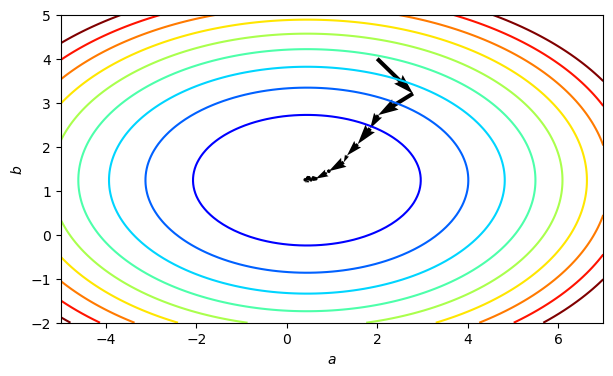

In [157]:
W0 = np.linspace(-5, 7, 101)
W1 = np.linspace(-2, 5, 101)
W0, W1 = np.meshgrid(W0,W1)
LOSSW = W0 * 0
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        wij = np.array([W0[i,j], W1[i,j]])
        LOSSW[i,j] = loss(wij, x_train, y_train)

contour_with_path(LOSSW, W0, W1, paths, norm=None, level=np.linspace(0, 10, 10))

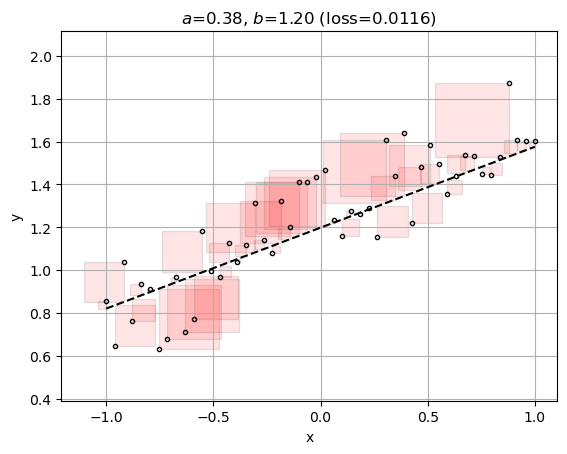

In [158]:
visualize_l2(w0[0], w0[1], x_train, y_train, loss(w0, x_train, y_train))

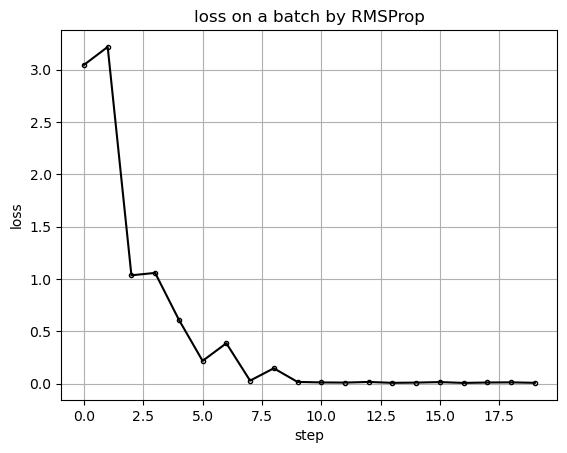

In [159]:
plt.plot(batch_loss, '.-k', markerfacecolor='none')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by RMSProp')
plt.show()

### 7.4.4 Adam (Adaptive Moment Estimation)

- Adam은 **모멘텀(Momentum)** 과 **RMSProp**을 결합한 형태의 옵티마이저임  
- 1차 모멘트(gradient의 평균)와 2차 모멘트(gradient 제곱의 평균)를 모두 추적함  
- 그래디언트의 **방향성과 크기 변동을 동시에 고려**하여 안정적이고 빠른 학습을 유도함  
- 학습 초기에 모멘트가 0으로 시작해 편향되는 문제를 방지하기 위해 **bias-correction(편향 보정)** 을 적용함  

#### 수식

각 step $t$에서:

1. **그래디언트 계산**  
   $$
   g_t = \nabla_\theta L(\theta_t)
   $$

2. **1차 모멘트(gradient 평균) 계산**  
   $$
   m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
   $$

3. **2차 모멘트(gradient 제곱 평균) 계산**  
   $$
   v_t = \beta_2 v_{t-1} + (1 - \beta_2) (g_t \odot g_t)
   $$

4. **편향 보정 (Bias Correction)**  
   $$
   \hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \qquad
   \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
   $$

5. **가중치 업데이트**  
   $$
   \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}} \odot \hat{m}_t
   $$

#### 하이퍼파라미터

- $\beta_1$: 1차 모멘텀 계수 (보통 0.9)  
- $\beta_2$: 2차 모멘텀 계수 (보통 0.999)  
- $\eta$: 학습률 (보통 0.001)  
- $\epsilon$: 0으로 나누는 것을 방지하는 작은 값 (보통 $10^{-8}$)

#### 동작 원리

- **모멘텀(m)**: 이전 그래디언트의 방향성을 유지하여 진동을 줄임  
- **스케일 보정(v)**: 최근 그래디언트의 제곱평균으로 파라미터별 학습률을 조정함  
- **편향 보정**: 초기에 $m_t$, $v_t$가 0에서 시작해 작게 추정되는 현상을 보정함  

#### 파라미터별 실제 업데이트 식

각 파라미터 $i$에 대해 보면:

$$
\theta_{t+1,i} = \theta_{t,i} - 
\frac{\eta}{\sqrt{\hat{v}_{t,i} + \epsilon}} \, \hat{m}_{t,i}
$$

즉,  
- $m_t$는 그래디언트의 평균을 추적하여 방향을 안정화함  
- $v_t$는 그래디언트의 크기를 추적하여 step size를 조절함  
- 두 정보를 결합해 빠르고 안정적인 수렴을 유도함  

#### 요약

- **Adam = Momentum + RMSProp**  
- 1차, 2차 모멘트를 함께 추적하여 **적응형 학습률**과 **관성 효과**를 동시에 반영함  
- 초기 편향 보정을 통해 안정적인 학습을 보장함  
- 대부분의 딥러닝 모델에서 **기본 옵티마이저로 널리 사용**됨  

In [160]:
# Adam
batch_size = 5 # 배치 크기
MaxEpochs = 10 # 반복 횟수

w0 = np.array([2.0, 4.0]) # 1) 초깃값
epsilon = 1.0
delta = 1E-8
rho1 = 0.9
rho2 = 0.999
s = np.zeros_like(w0)
r = np.zeros_like(w0)
t = 0

paths = []
batch_loss = []


In [161]:
print('Iter\tw_k\t\tgrad\t\tdw\t\tloss')
print('{:01d}-{:02d}\t{}'.format(1,0,np.array2string(w0, formatter={'float_kind':lambda x: "%.2f" % x})))

# 2) 데이터 셔플링 : 생략

# 알고리즘
for epoch in range(MaxEpochs): # 5) MaxEpochs번 반복
    k = 0
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train): # 3) 미니 배치 생성
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        grad = loss_grad(w0, x_batch, y_batch) # 4)-1 미니 배치에서 그래디언트 계산
        
        s = rho1 * s  + (1. - rho1) * grad
        r = rho2 * r  + (1. - rho2) * (grad * grad)
        
        t += 1
        
        shat = s / ( 1. - rho1 ** t)
        rhat = r / ( 1. - rho2 ** t)
        
        search_direction = -shat # 4)-2 탐색 방향 설정
        
        # 4)-3 학습률 설정        
        lr = epsilon / (delta + np.sqrt(rhat))
        dw = lr * search_direction # 4)-4 파라미터 업데이트
        w0 = w0 + dw
        
        print('{:01d}-{:02d}\t{}\t{}\t{}\t{:5.4f}'.format(epoch+1,k +1, 
            np.array2string(w0, formatter={'float_kind':lambda x: "%.2f" % x}),
            np.array2string(search_direction, formatter={'float_kind':lambda x: "%.2f" % x}),
            np.array2string(dw, formatter={'float_kind':lambda x: "%.2f" % x}),
            loss(w0, x_train, y_train)))
        k += 1

Iter	w_k		grad		dw		loss
1-00	[2.00 4.00]
1-01	[3.00 3.00]	[0.29 -2.32]	[1.00 -1.00]	2.6936
1-02	[2.41 2.03]	[-0.60 -1.90]	[-0.59 -0.97]	0.9926
1-03	[1.76 1.21]	[-0.57 -1.32]	[-0.65 -0.82]	0.3088
1-04	[1.16 0.51]	[-0.46 -0.99]	[-0.60 -0.71]	0.3680
1-05	[0.67 0.05]	[-0.34 -0.59]	[-0.49 -0.46]	0.7314
1-06	[0.26 -0.12]	[-0.26 -0.21]	[-0.41 -0.16]	0.9365
1-07	[0.11 -0.04]	[-0.10 0.10]	[-0.16 0.08]	0.8452
1-08	[-0.07 0.19]	[-0.10 0.29]	[-0.17 0.23]	0.6082
1-09	[-0.01 0.54]	[0.03 0.45]	[0.06 0.35]	0.2911
1-10	[-0.01 0.91]	[-0.00 0.45]	[-0.00 0.37]	0.1014
2-01	[0.03 1.25]	[0.02 0.40]	[0.04 0.34]	0.0402
2-02	[0.13 1.55]	[0.06 0.33]	[0.11 0.30]	0.0738
2-03	[0.26 1.78]	[0.06 0.25]	[0.12 0.23]	0.1602
2-04	[0.36 1.93]	[0.05 0.16]	[0.10 0.15]	0.2502
2-05	[0.41 1.99]	[0.02 0.06]	[0.05 0.06]	0.2943
2-06	[0.45 1.96]	[0.02 -0.03]	[0.04 -0.03]	0.2687
2-07	[0.40 1.84]	[-0.02 -0.12]	[-0.05 -0.12]	0.1895
2-08	[0.41 1.65]	[0.01 -0.18]	[0.01 -0.19]	0.0945
2-09	[0.35 1.43]	[-0.03 -0.21]	[-0.06 -0.22]	0.0289
2

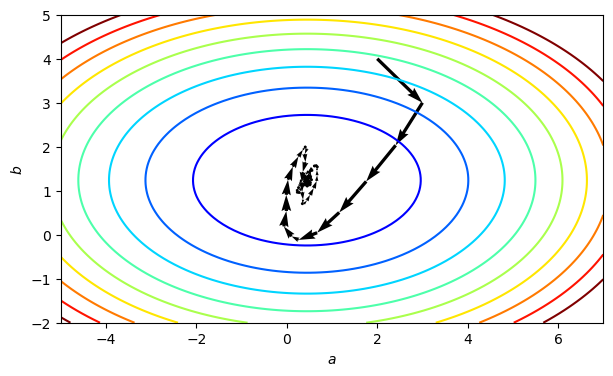

In [162]:
W0 = np.linspace(-5, 7, 101)
W1 = np.linspace(-2, 5, 101)
W0, W1 = np.meshgrid(W0,W1)
LOSSW = W0 * 0
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        wij = np.array([W0[i,j], W1[i,j]])
        LOSSW[i,j] = loss(wij, x_train, y_train)

contour_with_path(LOSSW, W0, W1, paths, norm=None, level=np.linspace(0, 10, 10))

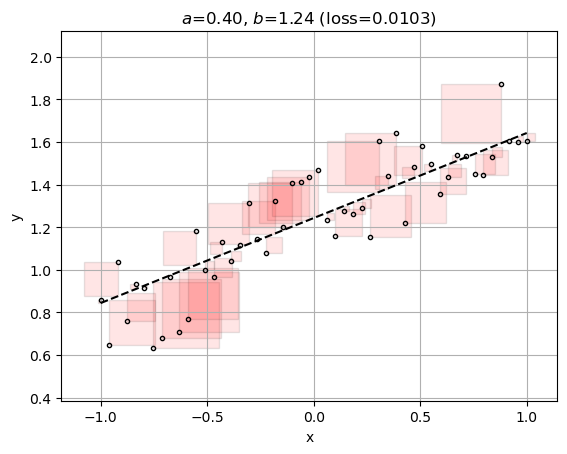

In [163]:
visualize_l2(w0[0], w0[1], x_train, y_train, loss(w0, x_train, y_train))

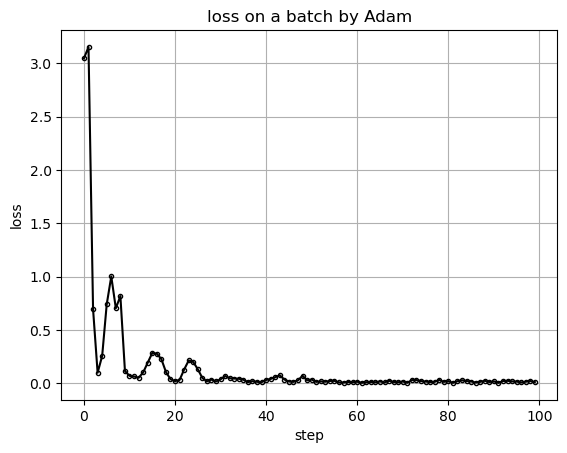

In [164]:
plt.plot(batch_loss, '.-k', markerfacecolor='none')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by Adam')
plt.show()